# Analyze and visualize last.fm listening history

To see this analysis live, check out my article ["Analyzing Last.fm Listening History"](http://geoffboeing.com/2016/05/analyzing-lastfm-history/)

The csv data files were created with [lastfm_downloader.ipynb](lastfm_downloader.ipynb)

In [2]:
import pandas as pd, numpy as np, string, re, pytz
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from datetime import datetime as dt
%matplotlib inline

In [3]:
# define the fonts to use for plots
family = 'DejaVu Sans'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=12, weight='normal', stretch='normal')
ticks_font_h = fm.FontProperties(family=family, style='normal', size=10.5, weight='normal', stretch='normal')

In [4]:
def get_colors(cmap, n, start=0., stop=1., alpha=1., reverse=False):
    '''return n-length list of rgba colors from the passed colormap name and alpha,
       limit extent by start/stop values and reverse list order if flag is true'''
    import matplotlib.cm as cm, numpy as np
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return list(reversed(colors)) if reverse else colors

## Top artists

In [5]:
artists_most = pd.read_csv('data/lastfm_top_artists.csv', encoding='utf-8')
artists_most = artists_most.set_index('artist')['play_count'].head(25)
artists_most.head()

artist
Miranda Lambert          1234
Explosions in the Sky     670
Dean Martin               530
Norah Jones               423
Jack Johnson              346
Name: play_count, dtype: int64

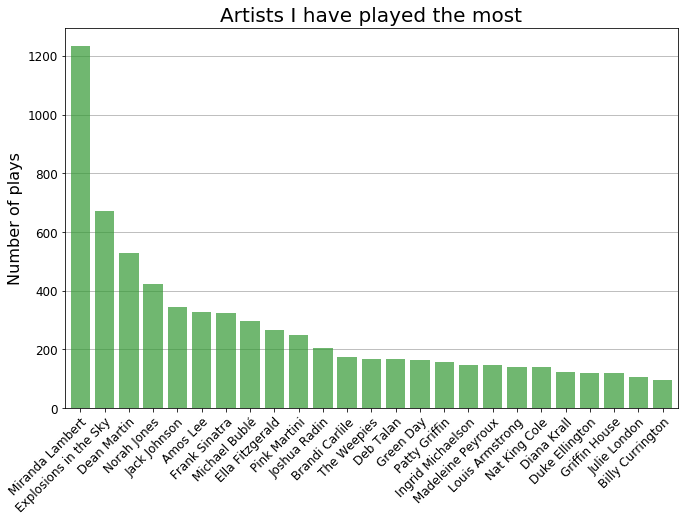

In [6]:
ax = artists_most.plot(kind='bar', figsize=[11, 7], width=0.8, alpha=0.7, color='#339933', edgecolor=None, zorder=2)

ax.yaxis.grid(True)
ax.set_xticklabels(artists_most.index, rotation=45, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Artists I have played the most', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Number of plays', fontproperties=label_font)

plt.savefig('images/lastfm-artists-played-most.png', dpi=96, bbox_inches='tight')
plt.show()

## Top tracks

In [7]:
tracks_most = pd.read_csv('data/lastfm_top_tracks.csv', encoding='utf-8')

def make_label(row, maxlength=30, suffix='...'):
    artist = row['artist']
    track = row['track']
    if len(track) > maxlength:
        track = '{}{}'.format(track[:maxlength-len(suffix)], suffix)
    return '{}\n{}'.format(artist, track)

index = tracks_most.apply(make_label, axis='columns')
tracks_most = tracks_most.set_index(index).drop(labels=['artist', 'track'], axis='columns')
tracks_most = tracks_most['play_count'].head(20)
tracks_most.head()

Miranda Lambert\nFor the Birds            47
Miranda Lambert\nWe Should Be Friends     43
Red Hot Chili Peppers\nSoul to Squeeze    39
Miranda Lambert\nWell-Rested              38
Miranda Lambert\nTo Learn Her             36
Name: play_count, dtype: int64

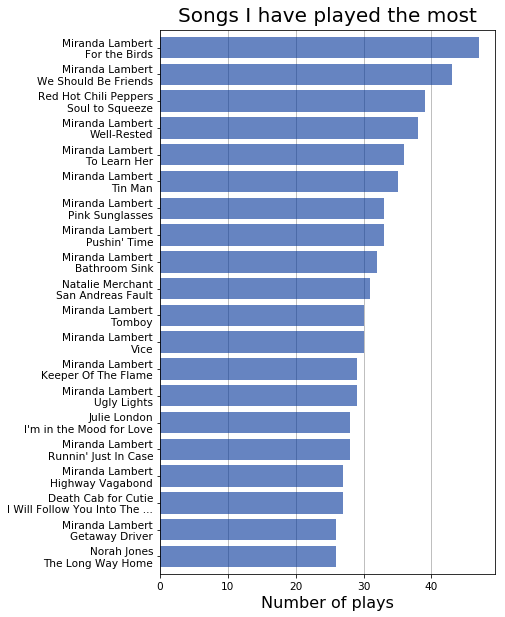

In [8]:
ax = tracks_most.sort_values().plot(kind='barh', figsize=[6, 10], width=0.8, alpha=0.6, 
                                    color='#003399', edgecolor=None, zorder=2)
ax.xaxis.grid(True)
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font_h)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font_h)
ax.set_xlabel('Number of plays', fontproperties=label_font)
ax.set_ylabel('', fontproperties=label_font)
ax.set_title('Songs I have played the most', fontproperties=title_font, y=1.005)

plt.savefig('images/lastfm-tracks-played-most-h.png', dpi=96, bbox_inches='tight')
plt.show()

## Top albums

In [9]:
albums_most = pd.read_csv('data/lastfm_top_albums.csv', encoding='utf-8')

def make_label(row, maxlength=25, suffix='...'):
    artist = row['artist']
    track = row['album']
    if len(track) > maxlength:
        track = '{}{}'.format(track[:maxlength-len(suffix)], suffix)
    return '{}\n{}'.format(artist, track)

index = albums_most.apply(make_label, axis='columns')
albums_most = albums_most.set_index(index).drop(labels=['artist', 'album'], axis='columns')
albums_most = albums_most['play_count'].head(30)
albums_most.head()

Miranda Lambert\nThe Weight of These Wings          693
Miranda Lambert\nPlatinum                           289
Dean Martin\nDino: The Essential De...              275
Explosions in the Sky\nThe Wilderness               140
Explosions in the Sky\nManglehorn (Original M...    138
Name: play_count, dtype: int64

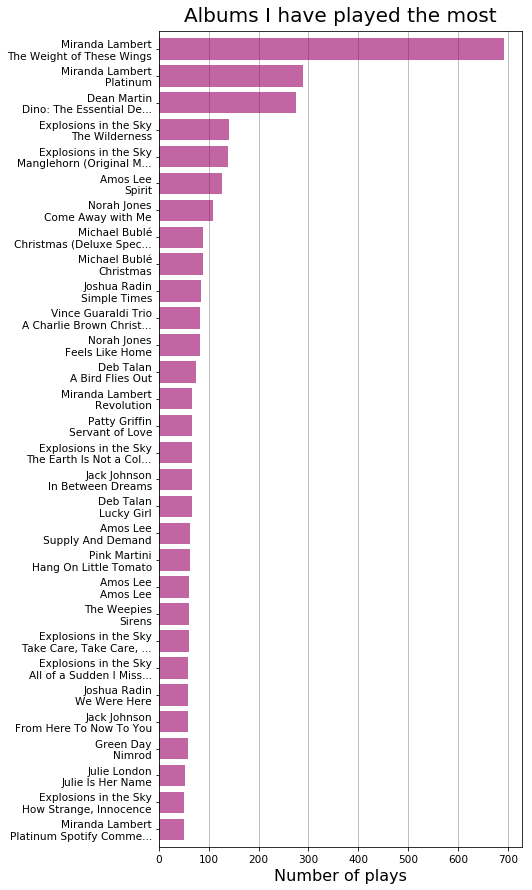

In [10]:
ax = albums_most.sort_values().plot(kind='barh', figsize=[6.5, 15], width=0.8, alpha=0.6, color='#990066', 
                                    edgecolor=None, zorder=2)
ax.xaxis.grid(True)
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font_h)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font_h)
ax.set_xlabel('Number of plays', fontproperties=label_font)
ax.set_ylabel('', fontproperties=label_font)
ax.set_title('Albums I have played the most', fontproperties=title_font, y=1.005)

plt.savefig('images/lastfm-albums-played-most-h.png', dpi=96, bbox_inches='tight')
plt.show()

## All-time scrobbles

In [11]:
# read the all-time scrobbles data set
scrobbles = pd.read_csv('data/lastfm_scrobbles.csv', encoding='utf-8')
scrobbles = scrobbles.drop('timestamp', axis=1)
print('{:,} total scrobbles'.format(len(scrobbles)))
print('{:,} total artists'.format(len(scrobbles['artist'].unique())))

19,632 total scrobbles
2,725 total artists


According to the last.fm web site, I have ~300,000 scrobbles. This API endpoint seems to miss the ones from before 2007.

In [12]:
# convert to datetime
scrobbles['timestamp'] = pd.to_datetime(scrobbles['datetime'])

In [13]:
# functions to convert UTC to Pacific time zone and extract date/time elements
convert_tz = lambda x: x.to_pydatetime().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('US/Pacific'))
get_year = lambda x: convert_tz(x).year
get_month = lambda x: '{}-{:02}'.format(convert_tz(x).year, convert_tz(x).month) #inefficient
get_day = lambda x: convert_tz(x).day
get_hour = lambda x: convert_tz(x).hour
get_day_of_week = lambda x: convert_tz(x).weekday()

These lambda functions are inefficient, but necessary to workaround this bug: https://github.com/pydata/pandas/issues/11757. I can update them when the bug is fixed in a future pandas version.

In [14]:
# parse out date and time elements as pacific time
scrobbles['year'] = scrobbles['timestamp'].map(get_year)
scrobbles['month'] = scrobbles['timestamp'].map(get_month)
scrobbles['day'] = scrobbles['timestamp'].map(get_day)
scrobbles['hour'] = scrobbles['timestamp'].map(get_hour)
scrobbles['dow'] = scrobbles['timestamp'].map(get_day_of_week)
scrobbles = scrobbles.drop(labels=['datetime'], axis=1)

# drop rows with 01-01-1970 as timestamp
scrobbles = scrobbles[scrobbles['year'] > 1970]
scrobbles.head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
0,Michael Bublé,611700cf-27f0-4dc9-ae80-c513a767853e,It's Time,cb15f5d0-1e03-48bb-b098-06f87e61494d,Save the Last Dance for Me,aeb8b330-e24c-463a-ad50-56dc7cb6ab36,2018-08-03 20:19:57,2018,2018-08,3,13,4
1,Ingrid Michaelson,1fc494a1-9109-4081-a455-2d05bea9d2bf,Be OK,bd049998-44f1-4ca1-9b38-853b25772a12,Keep Breathing,74f11f87-85fc-4364-b77c-a638ecbb2319,2018-08-03 20:16:30,2018,2018-08,3,13,4
2,Jon Peter Lewis,1804cd3a-4ca8-4fbb-be74-308dc8b3ebb6,Break The Silence,093f1aae-4c2b-4fd9-ba92-cb811d6a35ad,Tonight,2d3ce546-a3b6-4662-a68a-24d02abdebae,2018-08-03 20:14:16,2018,2018-08,3,13,4
3,SafetySuit,9247edb7-1bb5-43f2-a58f-185a8ba6044f,Hallelujah,177da40b-4249-4537-a614-47e392e8f57e,Never Stop (Wedding Version),6929e8cf-5379-4b6f-b77b-bdaadc6ed675,2018-08-03 20:11:21,2018,2018-08,3,13,4
4,Howard Shore,9b58672a-e68e-4972-956e-a8985a165a1f,"Ed Sheeran, The Hobbit: The Desolation Of Smau...",NaN,The Hobbit: The Desolation Of Smaug (Original ...,NaN,2018-08-03 20:06:18,2018,2018-08,3,13,4


All the last.fm timestamps of my scrobbles appear to be UTC, but the year, month, day, hour columns are now converted to Pacific Time (where I've done nearly all my listening)

## Year-by-year analysis

Visualize the number of scrobbles per year

In [15]:
year_counts = scrobbles['year'].value_counts().sort_index()

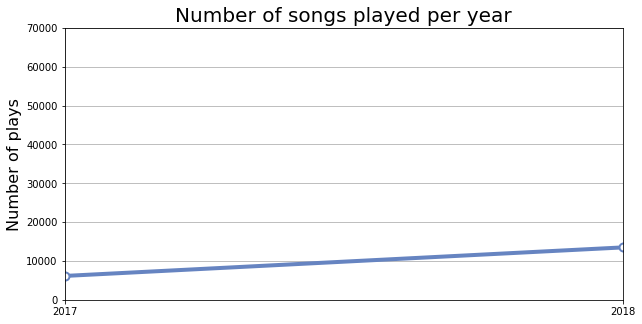

In [16]:
year_counts = scrobbles['year'].value_counts().sort_index()
ax = year_counts.plot(kind='line', figsize=[10, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.set_xlim((year_counts.index[0], year_counts.index[-1]))

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylim(0, 70000)
ax.set_xticks(year_counts.index)
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per year', fontproperties=title_font)

plt.savefig('images/lastfm-scrobbles-per-year.png', dpi=96, bbox_inches='tight')
plt.show()

## Month-by-month analysis

Visualize the number of scrobbles per month from 2010 through the present day

In [17]:
# get all the scrobbles from 2010-present
min_year = 2010
scrobbles_10 = scrobbles[scrobbles['year'] >= min_year]
max_year = max(scrobbles_10['year'])

In [18]:
# count number of scrobbles in each month
month_counts = scrobbles_10['month'].value_counts().sort_index()

# not every month necessarily has a scrobble, so fill in missing months with zero counts
date_range = pd.date_range(start=min(scrobbles_10['timestamp']), end=max(scrobbles_10['timestamp']), freq='D')
months_range = date_range.map(lambda x: str(x.date())[:-3])
index = np.unique(months_range)
month_counts = month_counts.reindex(index, fill_value=0)

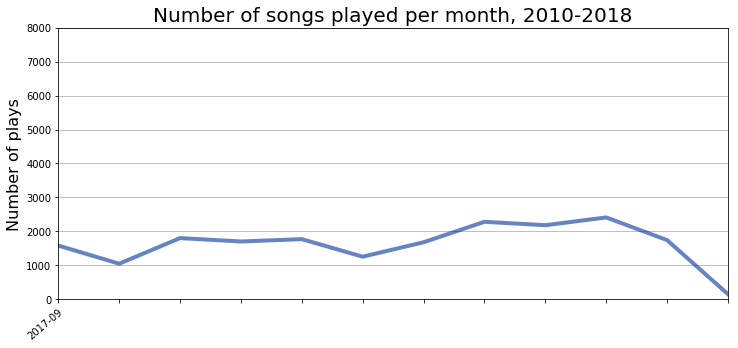

In [19]:
ax = month_counts.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=0.6, color='#003399')

xlabels = month_counts.iloc[range(0, len(month_counts), 12)].index
xlabels = [x if x in xlabels else '' for x in month_counts.index]
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=40, rotation_mode='anchor', ha='right')

ax.set_xlim((0, len(month_counts)-1))

ax.yaxis.grid(True)
ax.set_ylim((0,8000))
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per month, {}-{}'.format(min_year, max_year), fontproperties=title_font)

plt.savefig('images/lastfm-scrobbles-per-month.png', dpi=96, bbox_inches='tight')
plt.show()

## Day of the week analysis

How many songs have been played on each day of the week?

In [20]:
# get the play count sum by day of the week
dow_counts = scrobbles['dow'].value_counts().sort_index()
dow_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

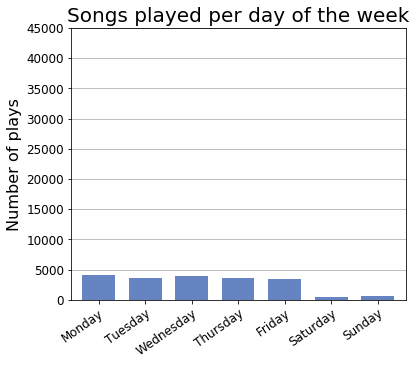

In [21]:
ax = dow_counts.plot(kind='bar', figsize=[6, 5], width=0.7, alpha=0.6, color='#003399', edgecolor=None, zorder=2)

ax.yaxis.grid(True)
ax.set_xticklabels(dow_counts.index, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_ylim((0, 45000))
ax.set_title('Songs played per day of the week', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Number of plays', fontproperties=label_font)

plt.savefig('images/lastfm-scrobbles-per-weekday.png', dpi=96, bbox_inches='tight')
plt.show()

## Hour of the day analysis

How many songs have been played during each hour of the day?

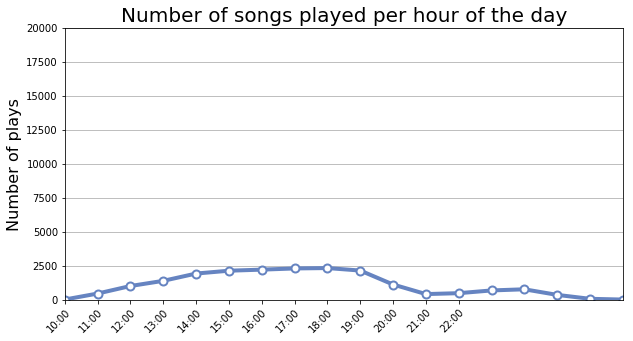

In [22]:
hour_counts = scrobbles['hour'].value_counts().sort_index()
ax = hour_counts.plot(kind='line', figsize=[10, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

xlabels = hour_counts.index.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.set_xlim((hour_counts.index[0], hour_counts.index[-1]))

ax.yaxis.grid(True)
ax.set_ylim((0, 20000))
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per hour of the day', fontproperties=title_font)

plt.savefig('images/lastfm-scrobbles-per-hour.png', dpi=96, bbox_inches='tight')
plt.show()

## Analysis by day of the week + hour of the day

How many songs have been played during each hour of the day on each day of the week?

In [23]:
# get the play counts by hour of day and day of week
weekday_hour_counts = scrobbles.groupby(['dow','hour']).count()['track']
hour_numbers = weekday_hour_counts.index.levels[1]
day_numbers = weekday_hour_counts.index.levels[0]
day_names = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

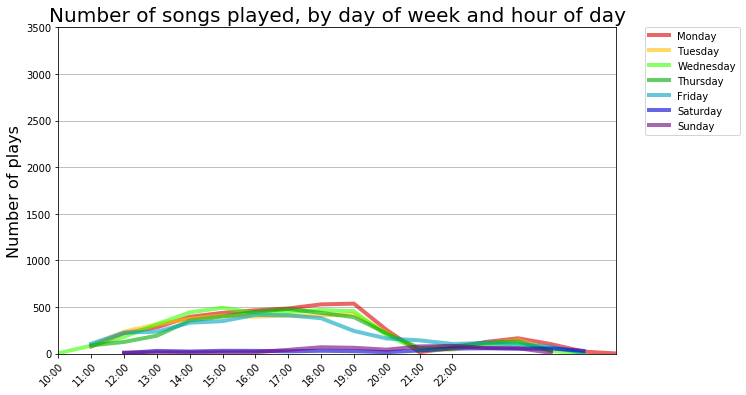

In [24]:
# get one color per day of week
colors = get_colors('nipy_spectral_r', n=len(day_numbers), start=0.1, stop=0.95)

fig, ax = plt.subplots(figsize=[10, 6])
lines = []
for day, c in zip(day_numbers, colors):
    ax = weekday_hour_counts[day].plot(kind='line', linewidth=4, alpha=0.6, c=c)
    lines.append(day_names[day])
    
xlabels = hour_numbers.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.set_xlim((hour_numbers[0], hour_numbers[-1]))

ax.yaxis.grid(True)
ax.set_ylim([0, 3500])
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played, by day of week and hour of day', fontproperties=title_font)
ax.legend(lines, loc='upper right', bbox_to_anchor=(1.23,1.017))

plt.savefig('images/lastfm-scrobbles-days-hours.png', dpi=96, bbox_inches='tight')
plt.show()

## Analysis of a single year (or multiple years)

Add additional years to the 'isin' list to query multiple years.

In [25]:
scrobbles_year = scrobbles[scrobbles['year'].isin([2015])]
len(scrobbles_year)

0

In [26]:
# what artists did i play the most that year?
artists_year = scrobbles_year['artist'].value_counts()
artists_year = pd.DataFrame(artists_year).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_year.index = [n + 1 for n in artists_year.index]
artists_year.head(10)

,artist,play count


In [27]:
# what tracks did i play the most that year?
tracks_year = scrobbles_year.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_year = tracks_year.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_year.index = [n + 1 for n in tracks_year.index]
tracks_year.head(10)

,artist,track,play count


In [28]:
# what albums did i play the most that year?
albums_year = scrobbles_year.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_year = albums_year.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_year.index = [n + 1 for n in albums_year.index]

# remove text in parentheses or brackets
regex = re.compile('\\(.*\\)|\\[.*]')
albums_year['album'] = albums_year['album'].map(lambda x: regex.sub('', x))
albums_year.head(10)

,artist,album,play count


## Analysis of a single month (or multiple months)

Add additional months to the 'isin' list to query multiple months.

In [29]:
scrobbles_month = scrobbles[scrobbles['month'].isin(['2014-02'])]
len(scrobbles_month)

0

In [30]:
# what artists did i play the most that month?
artists_month = scrobbles_month['artist'].value_counts()
artists_month = pd.DataFrame(artists_month).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_month.index = [n + 1 for n in artists_month.index]
artists_month.head(10)

,artist,play count


In [31]:
# what tracks did i play the most that month?
tracks_month = scrobbles_month.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_month = tracks_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_month.index = [n + 1 for n in tracks_month.index]
tracks_month.head(10)

,artist,track,play count


In [32]:
# what albums did i play the most that month?
albums_month = scrobbles_month.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_month = albums_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_month.index = [n + 1 for n in albums_month.index]
albums_month.head(10)

,artist,album,play count


## Listening history of a specific artist, album, or track

See the last 5 times I've listened to someone or something

In [36]:
# when were the last 5 times I played something by My Bloody Valentine?
scrobbles[scrobbles['artist'].str.contains('Explosions in the Sky')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
2909,Explosions in the Sky,4236acde-2ce2-441c-a3d4-38d55f1b5474,Manglehorn (Original Motion Picture Soundtrack),NaN,The Lift,NaN,2018-06-20 16:25:31,2018,2018-06,20,9,2
2910,Explosions in the Sky,4236acde-2ce2-441c-a3d4-38d55f1b5474,Manglehorn (Original Motion Picture Soundtrack),NaN,Peristalsis,NaN,2018-06-20 16:21:40,2018,2018-06,20,9,2
2911,Explosions in the Sky,4236acde-2ce2-441c-a3d4-38d55f1b5474,Manglehorn (Original Motion Picture Soundtrack),NaN,A Strange World,NaN,2018-06-20 16:19:36,2018,2018-06,20,9,2
2912,Explosions in the Sky,4236acde-2ce2-441c-a3d4-38d55f1b5474,Manglehorn (Original Motion Picture Soundtrack),NaN,Baseball Miracles,NaN,2018-06-20 16:17:20,2018,2018-06,20,9,2
2913,Explosions in the Sky,4236acde-2ce2-441c-a3d4-38d55f1b5474,Manglehorn (Original Motion Picture Soundtrack),NaN,Did I Scare You?,NaN,2018-06-20 16:14:55,2018,2018-06,20,9,2


In [37]:
# when were the last 5 times I played something off of Double Nickels on the Dime?
scrobbles[scrobbles['album'].fillna('').str.contains('Double Nickels')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow


In [38]:
# when were the last 5 times I played Personality Crisis?
scrobbles[scrobbles['track'].str.contains('Personality Crisis')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow


## Visualize top artists over time

How have the cumulative plays of most listened-to artists changed over time?

In [39]:
# get the cumulative play counts since 2009 for the top n most listened-to artists
n = 6
plays = scrobbles[scrobbles['artist'].isin(artists_most.head(n).index)]
plays = plays[plays['year'] >= 2009]
plays = plays.groupby(['artist','year']).count().groupby(level=[0]).cumsum()['track']

# make sure we have each year represented for each artist, even if they got no plays that year
plays = plays.unstack().T.fillna(method='ffill').T.stack()
top_artists = plays.index.levels[0]

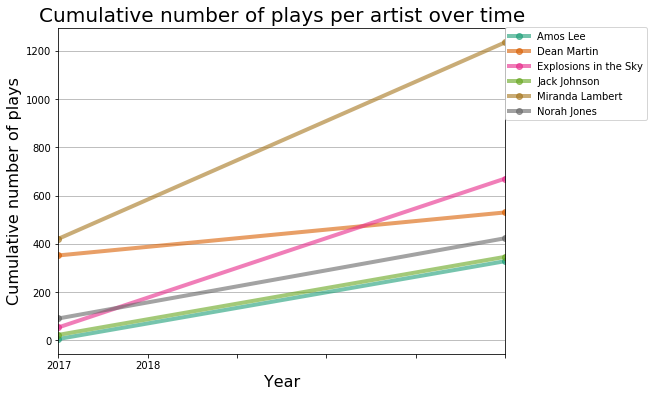

In [40]:
# get one color per artist
colors = get_colors('Dark2', n)

fig, ax = plt.subplots(figsize=[8, 6])
lines = []
for artist, c in zip(top_artists, colors):
    ax = plays[artist].plot(kind='line', linewidth=4, alpha=0.6, marker='o', c=c)
    lines.append(artist)
    
ax.set_xlim((plays.index.get_level_values(1).min(), plays.index.get_level_values(1).max()))

ax.yaxis.grid(True)
ax.set_xticklabels(plays.index.levels[1], rotation=0, rotation_mode='anchor', ha='center')
ax.set_ylabel('Cumulative number of plays', fontproperties=label_font)
ax.set_xlabel('Year', fontproperties=label_font)
ax.set_title('Cumulative number of plays per artist over time', fontproperties=title_font)
ax.legend(lines, loc='upper right', bbox_to_anchor=(1.33, 1.016))

plt.savefig('images/lastfm-scrobbles-top-artists-years.png', dpi=96, bbox_inches='tight')
plt.show()

## Characteristics of artists' names

Text analysis of artist name strings

In [41]:
# remove 'The ' and 'A ' preceding artist names, get unique set of names, then get first letter frequency
artists_clean = scrobbles['artist'].str.replace('The ','').str.replace('A ','')
first_letters = pd.Series(artists_clean.unique()).map(lambda x: x.upper()[0]).value_counts()
first_letters = first_letters[[c for c in string.ascii_uppercase]]

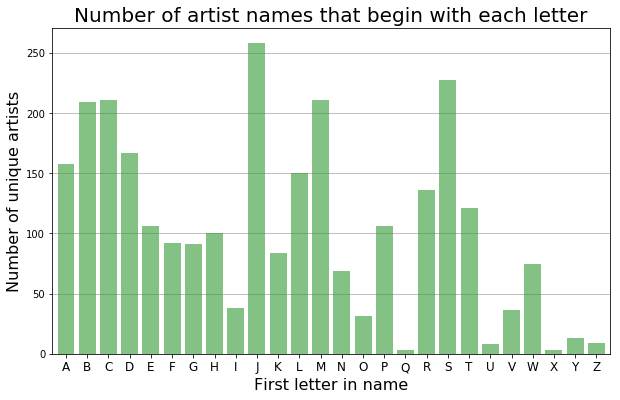

In [42]:
# plot the frequency of artist names that begin with each letter
ax = first_letters.plot(kind='bar', figsize=[10, 6], width=0.8, alpha=0.6, color='#339933', edgecolor=None, zorder=2)
ax.yaxis.grid(True)
ax.set_xticklabels(first_letters.index, rotation=0, rotation_mode='anchor', ha='center', fontproperties=ticks_font)

ax.set_title('Number of artist names that begin with each letter', fontproperties=title_font)
ax.set_xlabel('First letter in name', fontproperties=label_font)
ax.set_ylabel('Number of unique artists', fontproperties=label_font)

plt.savefig('images/lastfm-artists-first-letter-count.png', dpi=96, bbox_inches='tight')
plt.show()

In [43]:
# which artist names begin with the letter 'X'?
str(list(pd.Series(artists_clean[artists_clean.str.upper().str.startswith('X')].unique())))

"['Xavier Rudd', 'X Ambassadors', 'xx']"

In [44]:
# what are the most common first words in artist names that begin with 'M'?
artists_m = pd.Series(artists_clean[artists_clean.str.upper().str.startswith('M')].unique())
artists_m.map(lambda x: x.split()[0]).value_counts().head(15)

Michael    15
Matt        8
Mark        7
Marc        3
Mel         3
Matthew     3
My          3
Mason       2
Maroon      2
Milos       2
Modern      2
Marion      2
Mitch       2
Marcus      2
Molly       2
dtype: int64

In [45]:
# what are the most common first words in all the artist names?
pd.Series(scrobbles['artist'].unique()).map(lambda x: x.split()[0].lower()).value_counts().head(15)

the        209
john        28
chris       15
michael     15
johnny      15
david       14
charlie     12
james       11
ben         10
eric        10
paul        10
steve       10
bill         9
joe          8
kenny        8
dtype: int64

In [46]:
# what are the most common words in all the artist names, anywhere in the name?
word_list = []
stop_list = ['&','the','and','of','a','in','for','la','los','el','de','y']
for artist in artists_clean.unique():
    for word in artist.split():
        word_list.append(word.lower())

word_list = [word for word in word_list if word not in stop_list]
pd.Series(word_list).value_counts().head(15)

orchestra    53
john         33
his          32
(holiday)    27
band         23
smith        21
james        19
trio         19
brothers     18
lee          18
johnny       17
michael      17
chris        16
brown        15
williams     15
dtype: int64

In [47]:
# what is the longest artist name?
print('"{}"'.format(max(artists_clean, key=len)))

"Ian Sutherland, New World Philharmonic Orchestra & Tasmin Little"


In [48]:
# what is the distribution of lengths of artist names (up to n number of characters)?
n = 50
name_lengths = pd.Series([len(artist) for artist in artists_clean.unique()])
name_lengths = name_lengths.value_counts().sort_index()
name_lengths = name_lengths.iloc[0:n+1].reindex(range(n+1), fill_value=0)

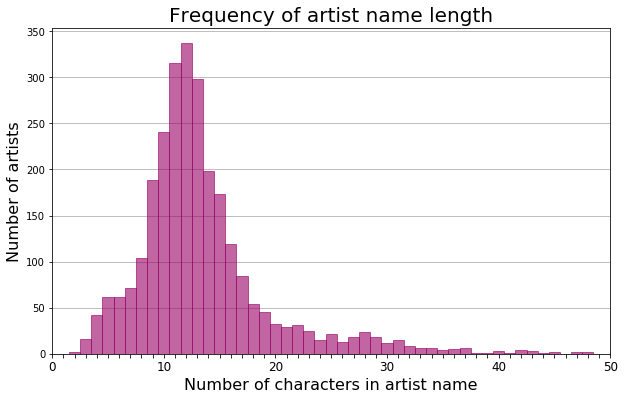

In [49]:
ax = name_lengths.plot(kind='bar', figsize=(10,6), alpha=0.6, width=1, color='#990066', edgecolor='#990066', zorder=2)

xlabels = [x if x % 10 == 0 else '' for x in name_lengths.index]
ax.set_xticklabels(xlabels, rotation=0, rotation_mode='anchor', ha='center', fontproperties=ticks_font)
ax.yaxis.grid(True)
ax.set_xlim((0,n))

ax.set_title('Frequency of artist name length', fontproperties=title_font)
ax.set_xlabel('Number of characters in artist name', fontproperties=label_font)
ax.set_ylabel('Number of artists', fontproperties=label_font)

plt.savefig('images/lastfm-artists-name-length.png', dpi=96, bbox_inches='tight')
plt.show()